In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Layer

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Conv1D, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ========================
# 1. CONFIGURATION
# ========================
# General settings
INPUT_STEPS = 10             # history length
FORECAST_STEPS = 10          # forecasting length
TEST_RATIO = 0.3             # 30% test set

# Tuning settings
EPOCHS_LIST = [20]       # Try different number of epochs
BATCH_SIZES = [128]      # Try different batch sizes

# Simulation settings
WINDOW_SIZE_SIMULATION = 10    # e.g. 6 hours = 36 steps if 10-min interval
THRESHOLD_PERCENTILE = 95         # Anomaly detection threshold

# Random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
file_path = '../../csv/rfcc_tuning_10min.csv'
df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

# Clean data
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns).astype(np.float32)

print(f"✅ Scaled dataset shape: {df_scaled.shape}")

# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================
split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

print(f"✅ Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

# ========================
# 5. SEQUENCE GENERATOR
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - forecast_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test, y_test = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

print(f"✅ Training sequences: {X_train.shape}, Testing sequences: {X_test.shape}")

# ========================
# 6. BUILD INFORMER-LIKE MODEL
# ========================


from tensorflow.keras.layers import Layer
import tensorflow as tf

class MultiHeadTopKSparseAttention(Layer):
    def __init__(self, num_heads=4, k=5, **kwargs):
        super(MultiHeadTopKSparseAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.k = k

    def build(self, input_shape):
        self.embed_dim = input_shape[0][-1]
        if self.embed_dim % self.num_heads != 0:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.depth = self.embed_dim // self.num_heads

        self.wq = tf.keras.layers.Dense(self.embed_dim)
        self.wk = tf.keras.layers.Dense(self.embed_dim)
        self.wv = tf.keras.layers.Dense(self.embed_dim)
        self.dense = tf.keras.layers.Dense(self.embed_dim)
        super().build(input_shape)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch, heads, seq_len, depth)

    def call(self, inputs):
        q_input, k_input, v_input = inputs
        batch_size = tf.shape(q_input)[0]

        q = self.wq(q_input)
        k = self.wk(k_input)
        v = self.wv(v_input)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(self.depth, tf.float32))
        top_k_values, top_k_indices = tf.math.top_k(scores, k=self.k, sorted=False)

        mask = tf.reduce_sum(tf.one_hot(top_k_indices, depth=tf.shape(scores)[-1]), axis=-2)
        mask = tf.cast(mask, dtype=tf.bool)
        padding_mask = tf.where(mask, tf.zeros_like(scores), -1e9 * tf.ones_like(scores))
        sparse_scores = scores + padding_mask
        attention_weights = tf.nn.softmax(sparse_scores, axis=-1)

        scaled_attention = tf.matmul(attention_weights, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))

        output = self.dense(concat_attention)
        return output

    def get_config(self):
        config = super(MultiHeadTopKSparseAttention, self).get_config()
        config.update({"num_heads": self.num_heads, "k": self.k})
        return config


def build_informer_like_model(input_steps, forecast_steps, input_dim, embed_dim=128, num_heads=4, top_k=5):
    inputs = tf.keras.Input(shape=(input_steps, input_dim))
    x = tf.keras.layers.Dense(embed_dim)(inputs)

    sparse_attention = MultiHeadTopKSparseAttention(num_heads=num_heads, k=top_k)
    attn_out = sparse_attention([x, x, x])

    x = tf.keras.layers.Add()([x, attn_out])
    x = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.Conv1D(filters=embed_dim, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=embed_dim, kernel_size=3, padding='same', activation='relu')(x)

    x = tf.keras.layers.RepeatVector(forecast_steps)(x[:, -1])
    x = tf.keras.layers.LSTM(embed_dim, return_sequences=True)(x)
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_dim))(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model



# ========================
# 7. TRAINING + TUNING LOOP
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training model with epochs={epochs}, batch_size={batch_size}")
        
        model = build_informer_like_model(INPUT_STEPS, FORECAST_STEPS, X_train.shape[2])
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit(X_train, y_train, 
                            validation_split=0.1,
                            epochs=epochs, 
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                           shuffle=False)
        
        # Evaluate on validation
        val_preds = model.predict(X_test, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), val_preds.reshape(-1)))
        val_mae = mean_absolute_error(y_test.reshape(-1), val_preds.reshape(-1))

        print(f"✅ Validation RMSE: {val_rmse:.5f}, MAE: {val_mae:.5f}")

        history_records.append({
            "epochs": epochs,
            "batch_size": batch_size,
            "val_rmse": val_rmse,
            "val_mae": val_mae
        })
        
        # Save the best model
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model

# Save all results
history_df = pd.DataFrame(history_records)
print("\n📋 Tuning Results Summary:")
print(history_df)

# Save best model
best_model.save("best_informer_forecaster.h5")
print("\n✅ Best model saved: best_informer_forecaster.h5")


✅ GPU is available and will be used.
✅ Scaled dataset shape: (57312, 71)
✅ Training samples: 40118, Testing samples: 17194
✅ Training sequences: (40098, 10, 71), Testing sequences: (17174, 10, 71)

🔵 Training model with epochs=20, batch_size=128
Epoch 1/20
282/282 [==============================] - 32s 36ms/step - loss: 0.0169 - val_loss: 0.0235
Epoch 2/20
282/282 [==============================] - 9s 31ms/step - loss: 0.0209 - val_loss: 0.0277
Epoch 3/20
282/282 [==============================] - 9s 31ms/step - loss: 0.0316 - val_loss: 0.0274
Epoch 4/20
282/282 [==============================] - 9s 31ms/step - loss: 0.0296 - val_loss: 0.0246
Epoch 5/20
282/282 [==============================] - 9s 31ms/step - loss: 0.0287 - val_loss: 0.0257
Epoch 6/20
135/135 [==============================] - 4s 19ms/step
✅ Validation RMSE: 0.19501, MAE: 0.09579

📋 Tuning Results Summary:
   epochs  batch_size  val_rmse   val_mae
0      20         128  0.195007  0.095789

✅ Best model saved: best_inf

In [5]:
# ========================
# 8. BUILD AND TRAIN LSTM AUTOENCODER
# ========================

def create_autoencoder_sequences(data, seq_len):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
    return np.array(X, dtype=np.float32)

X_ae_train = create_autoencoder_sequences(train_data.values, FORECAST_STEPS)

def build_lstm_autoencoder(input_steps, input_dim, units=128):
    inputs = Input(shape=(input_steps, input_dim))
    encoded = LSTM(units)(inputs)
    repeated = RepeatVector(input_steps)(encoded)
    decoded = LSTM(units, return_sequences=True)(repeated)
    outputs = Dense(input_dim)(decoded)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_ae = build_lstm_autoencoder(FORECAST_STEPS, X_ae_train.shape[2])

# Train Autoencoder
es = EarlyStopping(patience=5, restore_best_weights=True)
lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.1, epochs=20, batch_size=128, callbacks=[es], verbose=0,shuffle=False)
lstm_ae.save("best_lstm_autoencoder.h5")
print("\n✅ LSTM Autoencoder trained and saved.")

# ========================
# 9. REAL-TIME SIMULATION ON TEST SET
# ========================

# Create windows for real-time simulation
simulation_X, simulation_y = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

forecast_list = []
reconstruction_list = []
reconstruction_errors = []
anomaly_flags_list = []
true_windows = []  # ✅ add this

for i in range(0, len(simulation_X), WINDOW_SIZE_SIMULATION):
    window_X = simulation_X[i:i+1]
    window_y_true = simulation_y[i]    # ✅ just one true window

    y_pred_future = best_model.predict(window_X,batch_size=128, verbose=1)[0]
    X_forecast = np.expand_dims(y_pred_future, axis=0)
    y_reconstructed = lstm_ae.predict(X_forecast,batch_size=128, verbose=2)[0]

    reconstruction_error = np.mean((y_pred_future - y_reconstructed)**2, axis=1)
    threshold = np.percentile(reconstruction_error, THRESHOLD_PERCENTILE)
    anomaly_flags = reconstruction_error > threshold

    forecast_list.append(y_pred_future)
    reconstruction_list.append(y_reconstructed)
    reconstruction_errors.append(reconstruction_error)
    anomaly_flags_list.append(anomaly_flags)
    true_windows.append(window_y_true)  # ✅ collect the true future


print("\n✅ Real-time simulation complete.")




✅ LSTM Autoencoder trained and saved.
1/1 [==============================] - 0s 69ms/step
1/1 - 3s - 3s/epoch - 3s/step
1/1 [==============================] - 0s 74ms/step
1/1 - 0s - 89ms/epoch - 89ms/step
1/1 [==============================] - 0s 70ms/step
1/1 - 0s - 89ms/epoch - 89ms/step
1/1 [==============================] - 0s 71ms/step
1/1 - 0s - 90ms/epoch - 90ms/step
1/1 [==============================] - 0s 74ms/step
1/1 - 0s - 128ms/epoch - 128ms/step
1/1 [==============================] - 0s 64ms/step
1/1 - 0s - 98ms/epoch - 98ms/step
1/1 [==============================] - 0s 77ms/step
1/1 - 0s - 90ms/epoch - 90ms/step
1/1 [==============================] - 0s 75ms/step
1/1 - 0s - 94ms/epoch - 94ms/step
1/1 [==============================] - 0s 78ms/step
1/1 - 0s - 80ms/epoch - 80ms/step
1/1 [==============================] - 0s 71ms/step
1/1 - 0s - 89ms/epoch - 89ms/step
1/1 [==============================] - 0s 61ms/step
1/1 - 0s - 95ms/epoch - 95ms/step
1/1 [============


📈 Forecasting Evaluation on Test:
RMSE: 0.18772
MAE:  0.07497

📈 Anomaly Detection Evaluation:
Precision: 0.00000
Recall:    0.00000
F1 Score:  0.00000

✅ Metrics saved to 'metrics_informer_pipeline.csv'.


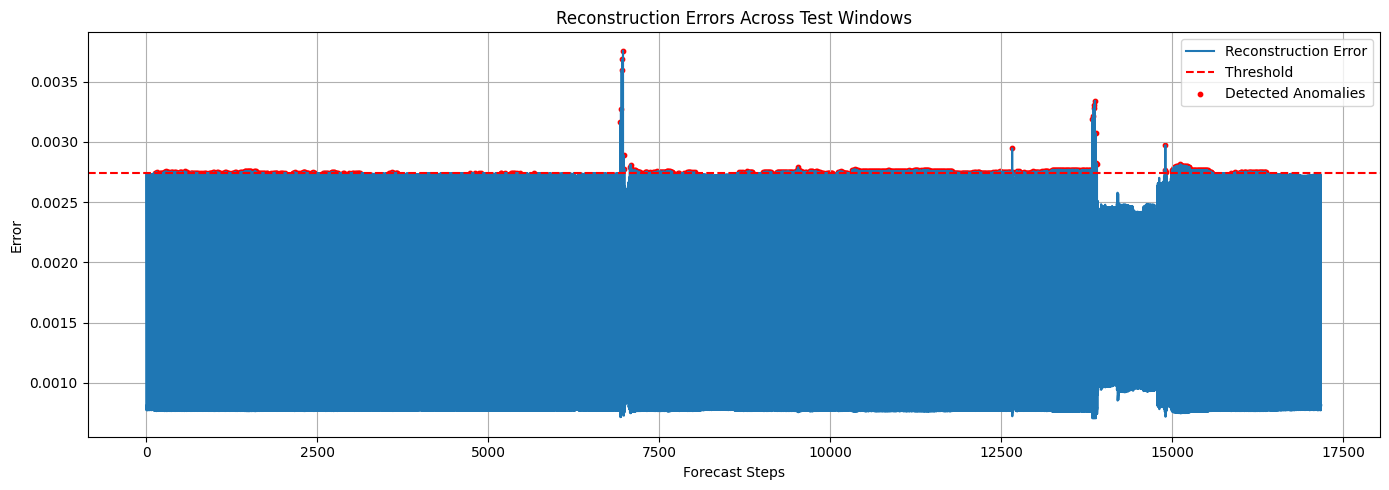

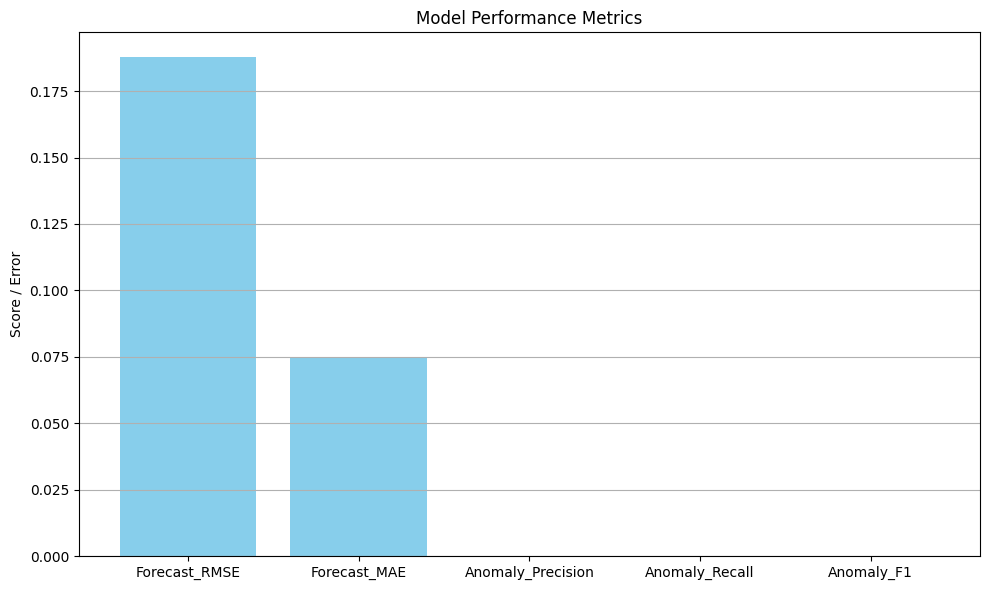

In [6]:
# ========================
# 10. EVALUATION METRICS
# ========================

# Forecasting evaluation
y_pred_all = np.vstack(forecast_list)
y_true_all = np.vstack(true_windows)  # ✅ matches exactly

forecast_rmse = np.sqrt(mean_squared_error(y_true_all.reshape(-1), y_pred_all.reshape(-1)))
forecast_mae = mean_absolute_error(y_true_all.reshape(-1), y_pred_all.reshape(-1))

print(f"\n📈 Forecasting Evaluation on Test:")
print(f"RMSE: {forecast_rmse:.5f}")
print(f"MAE:  {forecast_mae:.5f}")

# Anomaly detection evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

all_true_labels = np.zeros_like(np.hstack(anomaly_flags_list))  # Assume all normal (unsupervised)
all_detected = np.hstack(anomaly_flags_list)

precision = precision_score(all_true_labels, all_detected, zero_division=0)
recall = recall_score(all_true_labels, all_detected, zero_division=0)
f1 = f1_score(all_true_labels, all_detected, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# ========================
# 11. SAVE METRICS
# ========================

metrics_results = {
    "Model": "Informer + LSTM AE",
    "Forecast_RMSE": forecast_rmse,
    "Forecast_MAE": forecast_mae,
    "Anomaly_Precision": precision,
    "Anomaly_Recall": recall,
    "Anomaly_F1": f1
}

metrics_df = pd.DataFrame([metrics_results])
metrics_df.to_csv("metrics_informer_pipeline.csv", index=False)
print("\n✅ Metrics saved to 'metrics_informer_pipeline.csv'.")

# ========================
# 12. PLOTS
# ========================

# Plot Reconstruction Errors
plt.figure(figsize=(14,5))
all_errors = np.hstack(reconstruction_errors)
plt.plot(all_errors, label='Reconstruction Error')
plt.axhline(np.percentile(all_errors, THRESHOLD_PERCENTILE), color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)), 
            all_errors[all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)],
            color='red', label='Detected Anomalies', s=10)
plt.title("Reconstruction Errors Across Test Windows")
plt.xlabel("Forecast Steps")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_plot.png")
plt.show()

# Plot Metrics
metric_names = ["Forecast_RMSE", "Forecast_MAE", "Anomaly_Precision", "Anomaly_Recall", "Anomaly_F1"]
metric_values = [forecast_rmse, forecast_mae, precision, recall, f1]

plt.figure(figsize=(10,6))
plt.bar(metric_names, metric_values, color='skyblue')
plt.title("Model Performance Metrics")
plt.ylabel("Score / Error")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("metrics_bar_chart.png")
plt.show()
